<center><h1>Predict Customer Clicked Ads Classification</h1></center>

“Sebuah perusahaan di Indonesia ingin mengetahui efektifitas sebuah iklan yang mereka tayangkan, hal ini penting bagi perusahaan agar dapat mengetahui seberapa besar ketercapainnya iklan yang dipasarkan sehingga dapat menarik customers untuk melihat iklan. Dengan mengolah data historical advertisement serta menemukan insight serta pola yang terjadi, maka dapat membantu perusahaan dalam menentukan target marketing, fokus case ini adalah membuat model machine learning classification yang berfungsi menentukan target customers yang tepat ” 

## Import Relevant Packages

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

## Load Dataset

In [ ]:
try:
  df = pd.read_csv('Clicked Ads Dataset.csv', index_col=0)
except:
  !gdown 1uER-2pVVp4YUberlRznH5ETO30DfROQa
  df = pd.read_csv('Clicked Ads Dataset.csv', index_col=0)

Downloading...
From: https://drive.google.com/uc?id=1uER-2pVVp4YUberlRznH5ETO30DfROQa
To: /content/Clicked Ads Dataset.csv
100% 95.1k/95.1k [00:00<00:00, 71.0MB/s]


## Data Understanding

In [ ]:
df.sample(5)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
827,43.49,45,335778240.0,124.67,Perempuan,6/14/2016 12:08,Yes,Jakarta Barat,Daerah Khusus Ibukota Jakarta,Finance
845,44.16,42,431836510.0,133.42,Laki-Laki,5/25/2016 0:34,Yes,Makassar,Sulawesi Selatan,House
863,76.64,39,NaN,241.50,Laki-Laki,2/9/2016 23:38,No,Palembang,Sumatra Selatan,Finance
231,46.77,32,217650510.0,136.40,Laki-Laki,3/23/2016 6:00,Yes,Tasikmalaya,Jawa Barat,Fashion
430,88.72,32,307093570.0,211.87,Laki-Laki,1/3/2016 17:10,No,Bogor,Jawa Barat,Health


**Analisa Output**
- Kolom `Daily Time Spent on Site`, `Age`, `Area Income`, `Daily Internet Usage` adalah numerikal
- Kolom `Male`, `city`, `province`, `category` adalah kolom kategorikal
- Kolom `Timestamp` adalah kolom datetime
- Kolom `Clicked on Ad` adalah kolom target 

**Keterangan Kolom** 
- 'Daily Time Spent on Site': Waktu yang dihabiskan konsumen pada situs web dalam hitungan menit
- 'Age': Usia konsumen
- 'Area Income': Rata-rata Pendapatan wilayah geografis konsumen
- 'Daily Internet Usage': Rata-rata menit harian yang dihabiskan konsumen dalam berinternet
- 'City': Kota konsumen
- 'Male': Jenis Kelamin
- 'Timestamp': Waktu di mana konsumen mengklik atau menutup iklan
- 'Clicked on Ad': Apakah konsumen mengklik iklan?

### Check DataFrame Info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  987 non-null    float64
 1   Age                       1000 non-null   int64  
 2   Area Income               987 non-null    float64
 3   Daily Internet Usage      989 non-null    float64
 4   Male                      997 non-null    object 
 5   Timestamp                 1000 non-null   object 
 6   Clicked on Ad             1000 non-null   object 
 7   city                      1000 non-null   object 
 8   province                  1000 non-null   object 
 9   category                  1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 85.9+ KB


In [ ]:
#check apakah kolom area income cocok dijadikan integer

print(np.array_equal(df['Area Income'].fillna(df['Area Income'].median()), df['Area Income'].fillna(df['Area Income'].median()).astype(int)))

False


**Analisa Output**
- Kolom `Daily Time Spent on Site`, `Area Income`, `Daily Internet Usage`       dan `Male` terdapat missing value
- Kolom `Timestamp` dapat dikonversi menjadi datetime 
- Kolom 'Clicked on Ad' dapat dikonversi menjadi numerikal/boolean dengan 'Ya' = 1, atau 'No' = 0            

### Check Duplicates

In [ ]:
print('Data Duplikat = ', df.duplicated().sum())

Data Duplikat =  0


Tidak ada data yang duplikat

### Check Missing Value

In [ ]:
df.isnull().sum()

Daily Time Spent on Site    13
Age                          0
Area Income                 13
Daily Internet Usage        11
Male                         3
Timestamp                    0
Clicked on Ad                0
city                         0
province                     0
category                     0
dtype: int64

Jumlah nilai null tidak begitu besar sehingga bisa ditoleransi di drop atau bisa juga dilakukan imputasi median/mode.

### Check Unique Values

In [ ]:
df.nunique()

Daily Time Spent on Site    890
Age                          43
Area Income                 987
Daily Internet Usage        955
Male                          2
Timestamp                   997
Clicked on Ad                 2
city                         30
province                     16
category                     10
dtype: int64

In [ ]:
for x in df.select_dtypes(include='object').columns:
  print(df[x].value_counts(normalize=True)*100)

Perempuan    51.955868
Laki-Laki    48.044132
Name: Male, dtype: float64
5/26/2016 15:40    0.2
5/30/2016 8:02     0.2
5/20/2016 12:17    0.2
5/15/2016 3:10     0.1
4/5/2016 8:18      0.1
                  ... 
5/12/2016 4:35     0.1
1/1/2016 21:58     0.1
3/13/2016 13:50    0.1
7/16/2016 14:13    0.1
6/3/2016 21:43     0.1
Name: Timestamp, Length: 997, dtype: float64
No     50.0
Yes    50.0
Name: Clicked on Ad, dtype: float64
Surabaya             6.4
Bandung              6.4
Jakarta Timur        6.3
Jakarta Selatan      6.1
Jakarta Barat        5.7
Bekasi               5.6
Medan                4.8
Jakarta Utara        4.5
Palembang            4.2
Semarang             4.1
Batam                3.4
Makassar             3.3
Tangerang Selatan    3.3
Tangerang            3.2
Depok                3.0
Bandar Lampung       2.9
Bogor                2.8
Jakarta Pusat        2.7
Malang               2.6
Banjarmasin          2.3
Pakanbaru            2.3
Denpasar             2.1
Padang             

Terlihat kolom city, province, dan category memiliki nilai unique yang tinggi apabila diperlukan pada feature selection nanti, dilakukan one hot encoding

## Feature Engineering

### Casting Tipe Data

In [ ]:
#mengubah timestamp menjadi datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [ ]:
#clicked on ad jadi numerik
df['Clicked on Ad'] = df['Clicked on Ad'].map({
    'No' : 0,
    'Yes' : 1,
})

In [ ]:
df['Month'] = df['Timestamp'].dt.month

In [ ]:
df['Date'] = df['Timestamp'].dt.day

In [ ]:
df['Day'] = df['Timestamp'].dt.dayofweek

In [ ]:
df['Hour'] = df['Timestamp'].dt.hour

## Exploratory Data Analysis

### Statistic Descriptive

In [ ]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad,Month,Date,Day,Hour
count,987.000000,1000.000000,9.870000e+02,989.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,64.929524,36.009000,3.848647e+08,179.863620,0.50000,3.817000,15.484000,3.064000,11.660000
std,15.844699,8.785562,9.407999e+07,43.870142,0.50025,1.926973,8.734073,1.998474,6.960952
min,32.600000,19.000000,9.797550e+07,104.780000,0.00000,1.000000,1.000000,0.000000,0.000000
25%,51.270000,29.000000,3.286330e+08,138.710000,0.00000,2.000000,8.000000,1.000000,6.000000
50%,68.110000,35.000000,3.990683e+08,182.650000,0.50000,4.000000,15.000000,3.000000,12.000000
75%,78.460000,42.000000,4.583554e+08,218.790000,1.00000,5.000000,23.000000,5.000000,18.000000
max,91.430000,61.000000,5.563936e+08,267.010000,1.00000,7.000000,31.000000,6.000000,23.000000


In [ ]:
df.describe(include=['O'])

,Male,city,province,category
count,997,1000,1000,1000
unique,2,30,16,10
top,Perempuan,Surabaya,Daerah Khusus Ibukota Jakarta,Otomotif
freq,518,64,253,112


- Terlihat sebaran data cukup baik dengan mayoritas kolom terlihat hampir mendekati normal
- Konsumen didominasi oleh perempuan
- Konsumen terbanyak berasal dari kota Surabaya
- Namun, secara provinsi lebih banyak dari DKI Jakarta
- Iklan yang sering di muncul adalah Otomotif

### Univariate Analysis

In [ ]:
#separate numerical and categorical columns
num_var = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_var = df.select_dtypes(include=['object']).columns.to_list()

num_var.remove('Clicked on Ad')

In [ ]:
print(len(num_var))
print(len(cat_var))

8
4


#### Numerical Variables

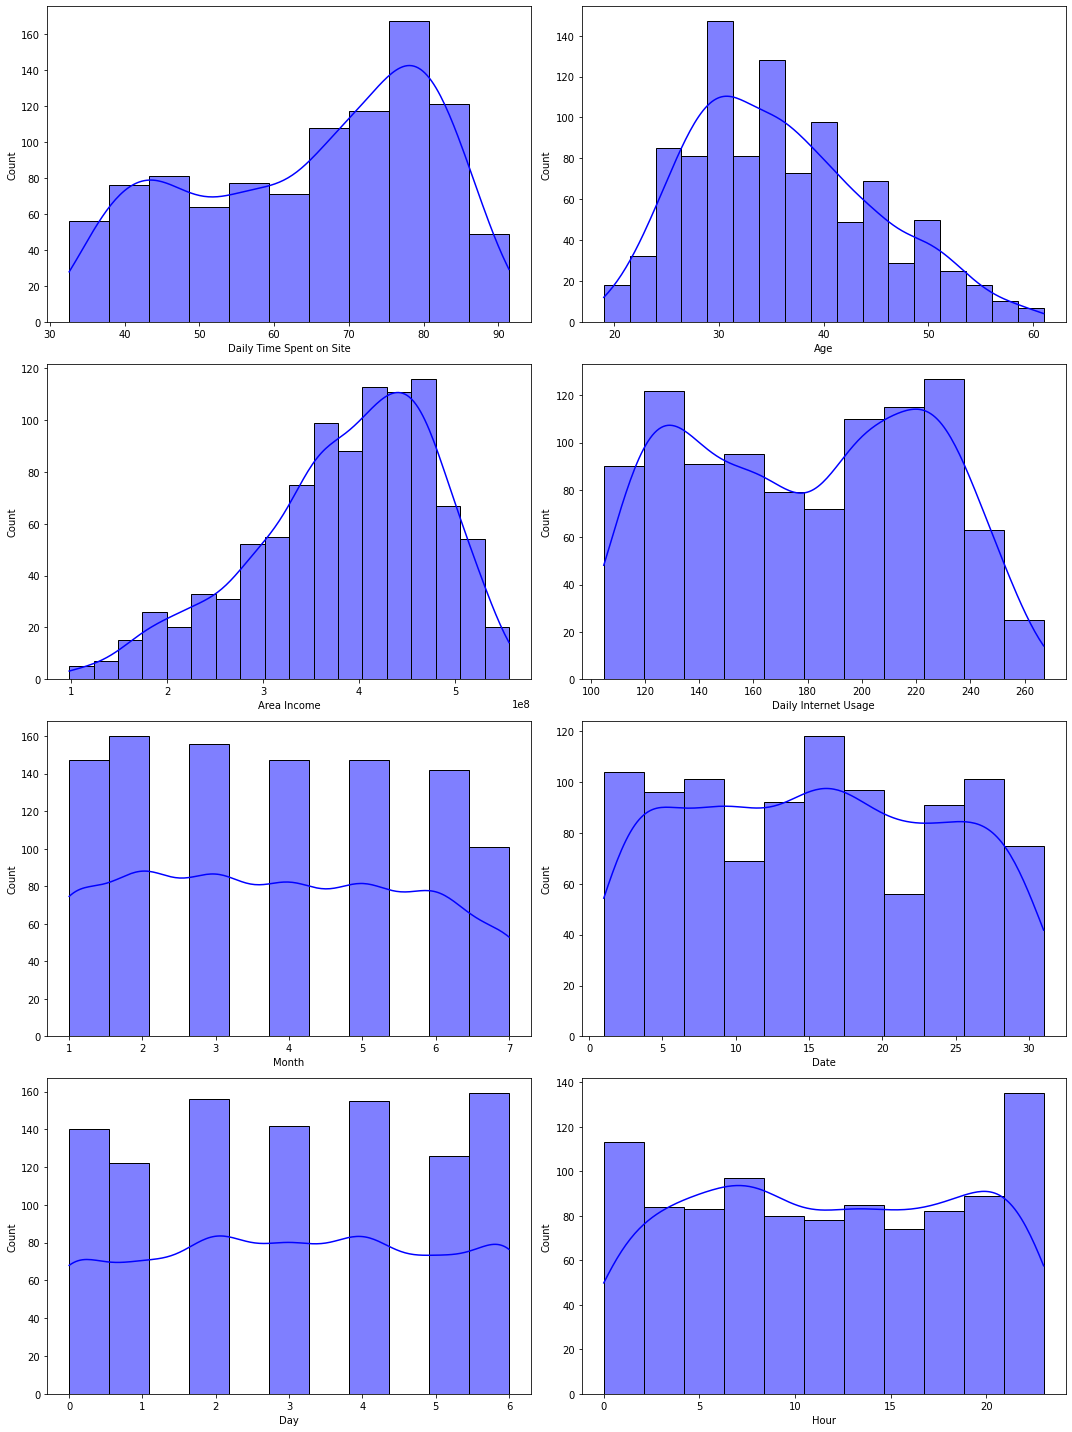

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(0, len(num_var)):
    plt.subplot(4, 2, i+1)
    sns.histplot(df[num_var[i]], color='blue', kde=True)
    plt.tight_layout()

- Kolom `Area Income` tampaknya skew dan kemungkinan ada outliers
- Setiap hari pengguna berada di situs web waktu 40-85 menit
- usia pengguna paling banyak di sekitara umur 25 - 40
- Income tertinggi berada di antara 400.000.000 -  500.000.000
- pengguna kebanyakan menghabiskan waktu bermain internet 220-240 menit

##### Check Skew

-    If skewness is less than -1 or greater than 1, the distribution is highly skewed.
-    If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
-    If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

In [ ]:
df[num_var].skew()

Daily Time Spent on Site   -0.369756
Age                         0.479142
Area Income                -0.644302
Daily Internet Usage       -0.031395
Month                       0.090786
Date                        0.043947
Day                        -0.027938
Hour                       -0.001035
dtype: float64

Hampir semua kolom mendekati distribusi normal, kecuali area income yang mengalami moderate skew

##### Check Outliers

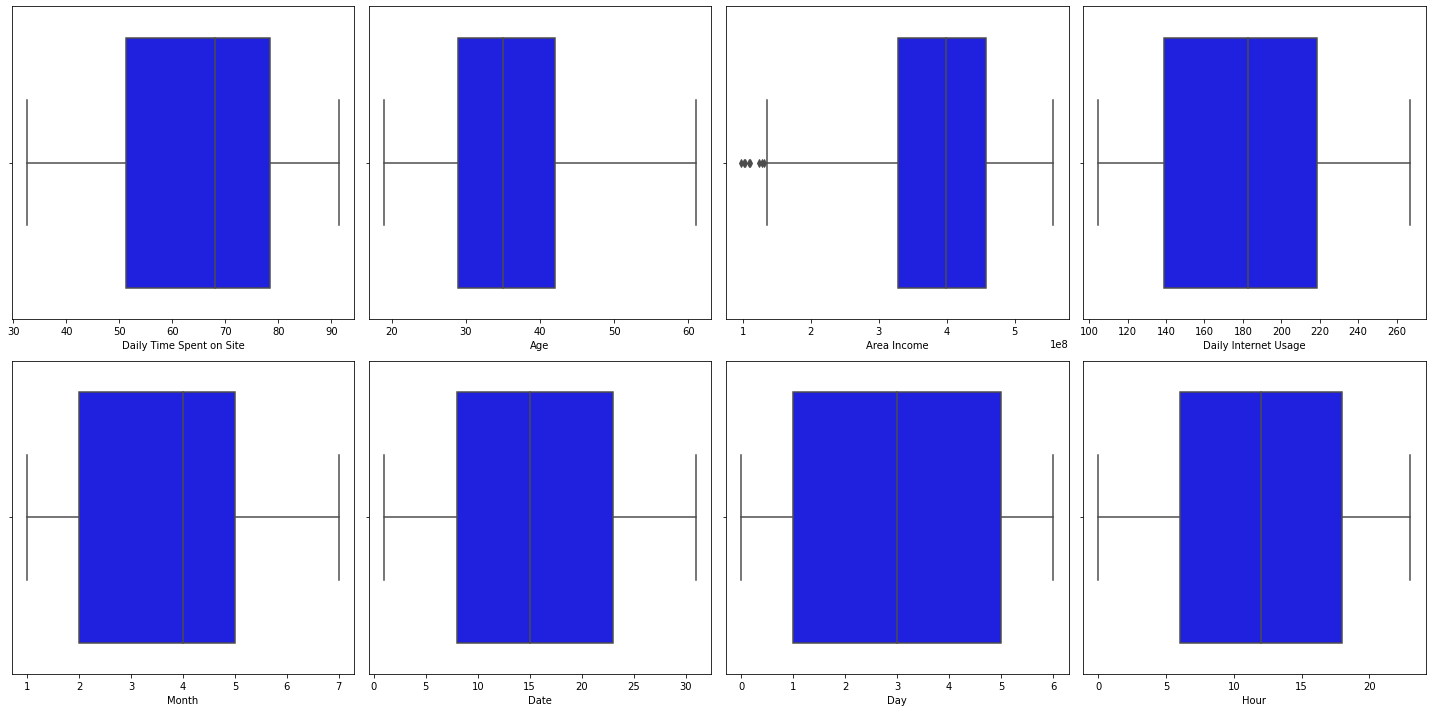

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(0, len(num_var)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(df[num_var[i]], color='blue')
    plt.tight_layout()

Terdapat sedikit outliers pada kolom area income sepertinya tidak menggangu

In [ ]:
def find_outliers(df):
  q1= df.quantile(0.25)
  q3= df.quantile(0.75)
  IQR = q3 - q1
  low_limit = q1 - (1.5 * IQR)
  high_limit = q3 + (1.5 * IQR)
  
  outliers = df[((df<(q1 - 1.5*IQR)) | 
                 (df>(q3 + 1.5*IQR))).any(axis=1)]

  return outliers

find_outliers(df[num_var])

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Month,Date,Day,Hour
135,49.89,39,123969860.0,160.03,4,16,5,12
510,57.86,30,131735380.0,166.86,7,8,4,17
640,64.63,45,109188030.0,158.80,6,12,6,3
665,58.05,32,111153700.0,195.54,2,12,4,10
692,66.26,47,101836420.0,179.04,4,25,0,19
768,68.58,41,97975500.0,171.54,7,6,2,12
778,52.67,44,103428500.0,191.26,5,19,3,6
952,62.79,36,128579990.0,231.87,5,30,0,20


#### Categorical Variables

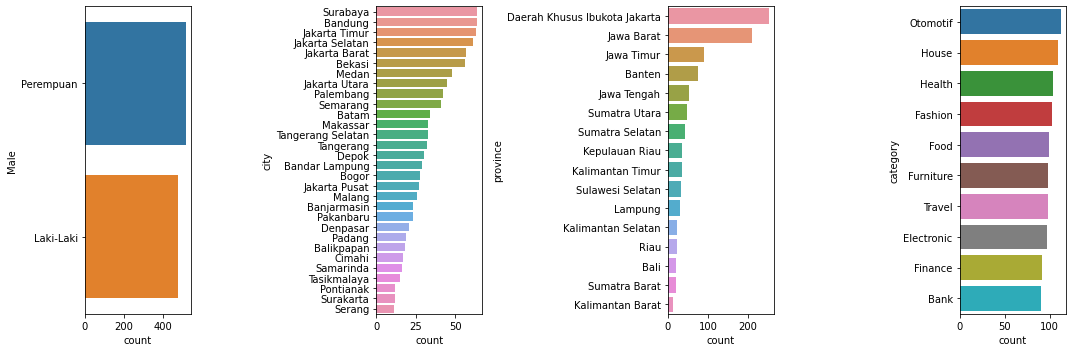

In [ ]:
plt.figure(figsize=(15, 5))
for i in range(0, len(cat_var)):
    plt.subplot(1, 4,i+1)
    sns.countplot(y=df[cat_var[i]], order=df[cat_var[i]].value_counts().index, orient='v')
    plt.tight_layout()

- Terlihat bahwa pengguna mayoritas dari pulau jawa dan ini sangat masuk akal mengingat bahwa penduduk terbanyak di indonesia berada di pulau jawa
- Untuk kategori hampir terlihat seiimbang antara 90-100

#### Target Feature

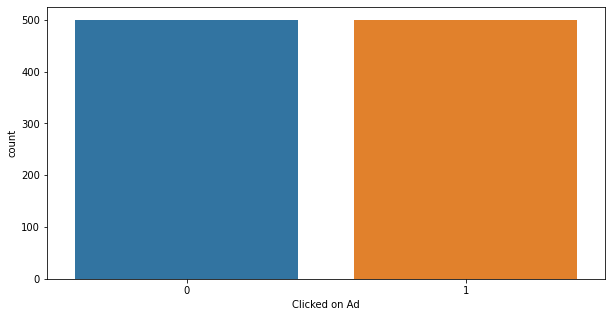

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['Clicked on Ad'])
plt.show()

Terlihat bahwa target seiimbang, sehingga data termasuk balanced dataset

### Bivariate Analysis

#### Numerical - Target

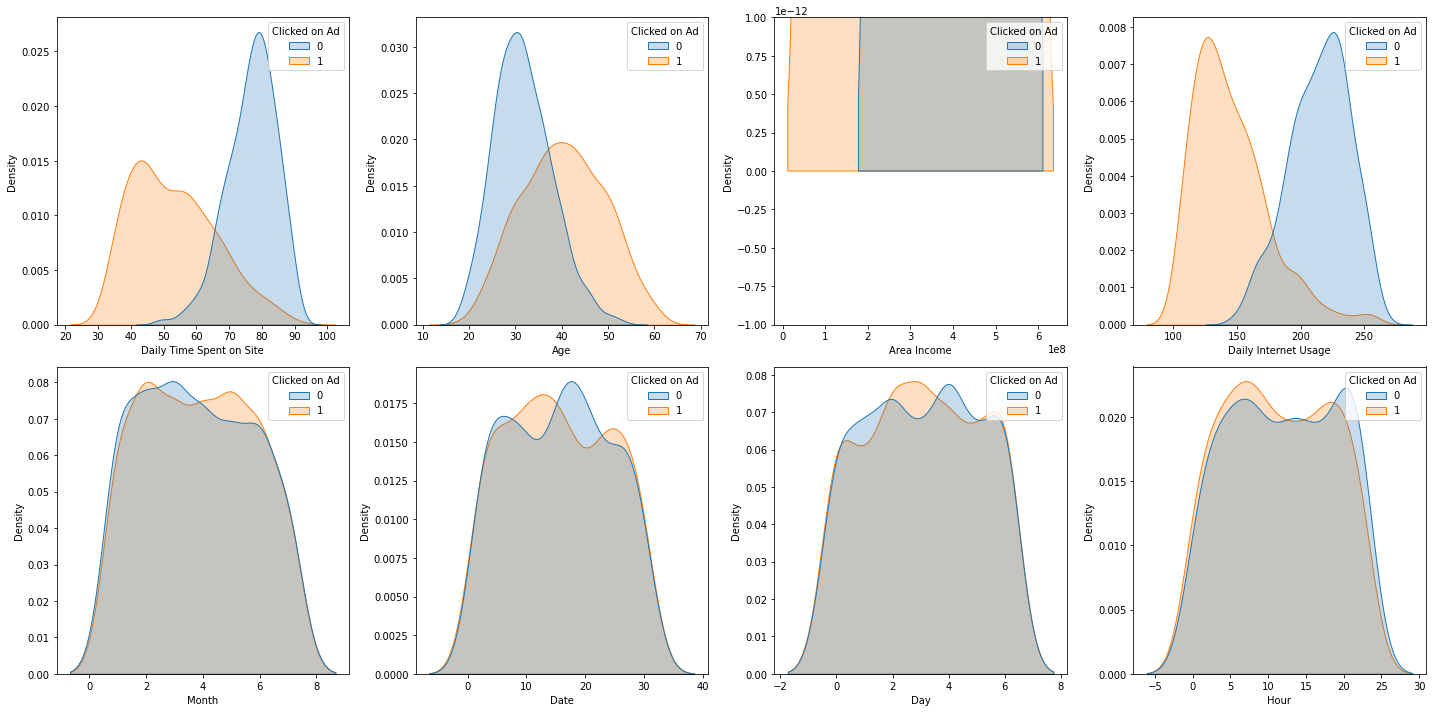

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(0, len(num_var)):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(df[num_var[i]], color='blue', shade=True, hue=df['Clicked on Ad'])
    plt.tight_layout()

**Analisa Output**
- Terlihat pemisahaan antara beberapa kolom cukup baik sehingga mudah dikenali
- Konsumen yang mengunjungi situs web selama kurang dari 65 menit cenderung menutup iklan, sedangkan diatas 65 lebih banyak mengklik iklan
- Usia konsumen diatas 40 cenderung mengklik iklan, sedangkan di bawah 40 tahun cenderung menutup iklan
- Ternyata, konsumen yang menghabiskan waktu diinternet kurang dari 175 cenderung lebih tertarik mengklik iklan dibanding orang yang lebih dari 175 menit menghabiskan waktunya.
- Dapat disimpulkan bahwa Daily internet usage dan daily time spent sepertinya berkorelasi.
- Dilihat dari tanggal, tanggal ke 12 kebanyakan mengklik iklan sedangkan hari ke 18 kebanyakan menutup iklan, ada apa dengan hari itu?
- kebanyakan mengklik iklan di hari kamis
- pada hari 2-4 jumlah konsumen mengklik iklan seperti menurun, sedangkan pada bulan ke 4-7 jumlah mengklik iklan menaik 

#### Categorical - Target

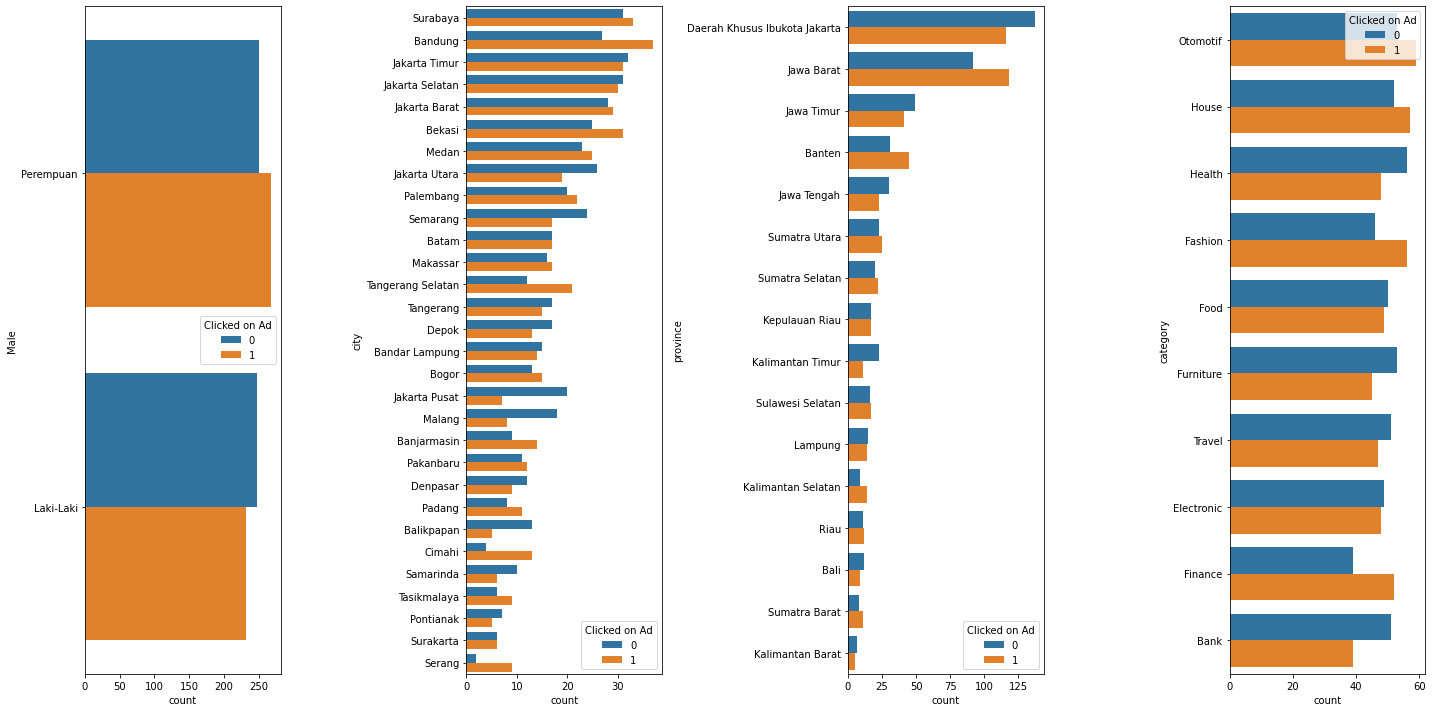

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(0, len(cat_var)):
    plt.subplot(1, 4,i+1)
    sns.countplot(y=df[cat_var[i]], order=df[cat_var[i]].value_counts().index, orient='v', hue=df['Clicked on Ad'])
    plt.tight_layout()

**Analisa Output**
- Konsumen perempuan sepertinya sedikit lebih tergiur mengklik iklan dibanding laki-laki
- Kota Bandung dan Bekasi adalah kota yang konsumen lebih banyak mengklik iklan
- Jakut, Semarang, Jakpus, Malang, adalah kota yang didominasi penutup iklan
- DKI Jakarta di dominasi penutup iklan, sedangkan Jabar didominasi pengklik iklan
- Iklan yang terbanyak di klik adalah Finance dan Fashion
- sedangkan iklan yang paling banyak ditutup adalah bank, furniture dan health

#### Numerical - Numerical

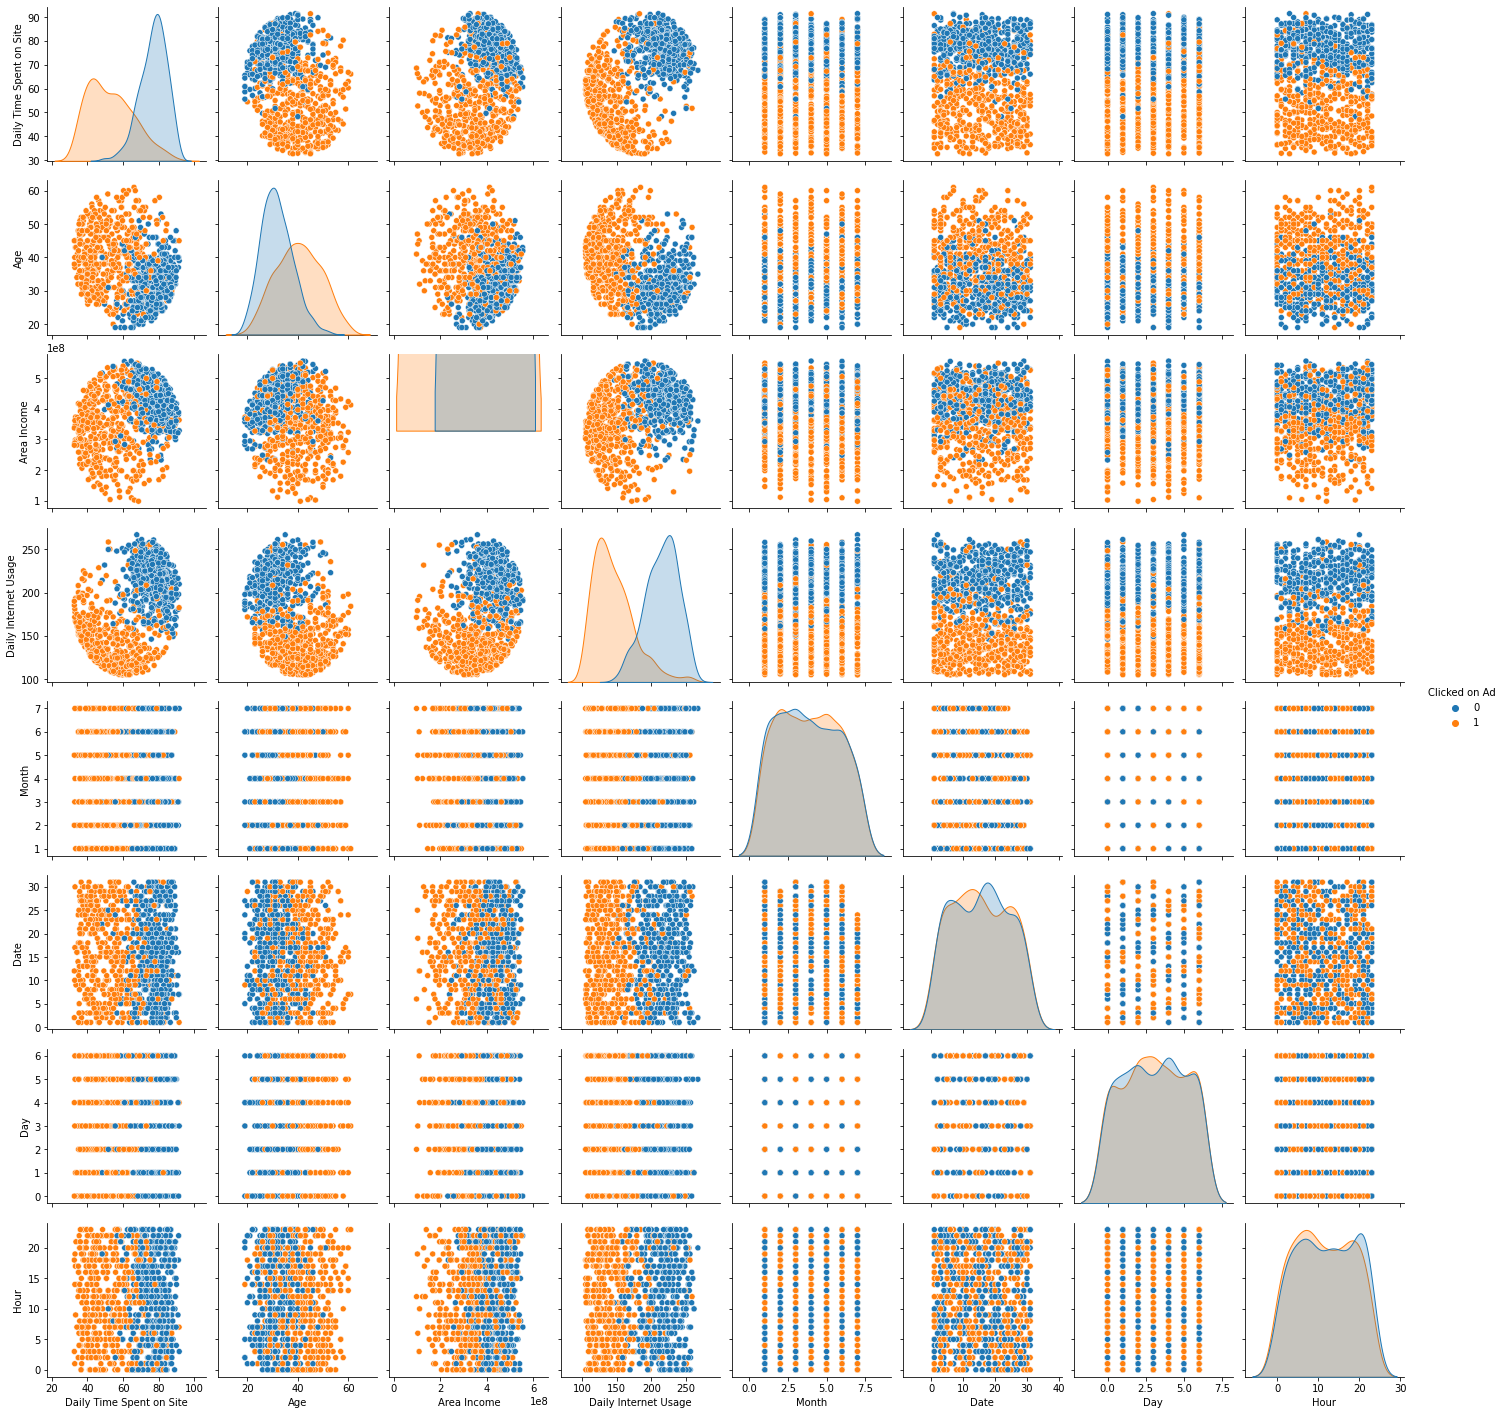

In [ ]:
sns.pairplot(df, hue='Clicked on Ad')
plt.show()

**Analisa Output**
- Terlihat bahwa pemisahan antar klaster pengklik dan penutup iklan cukup terpisah dengan baik, sehingga nantinya dapat diaplikasikan model Logistik Regression

- Daily Time Spend
  - Age; semakin sedikit waktu yang dihabiskan semakin berpotensi mengklik iklan
  - Area Income; semakin sedikit waktu yang dihabiskan semakin berpotensi mengklik iklan
  - Daily Internet Usage; Semakin rendah waktu konsumsi harian internet yang dihabiskan, seberapun waktu yang dihabiskan di situs web, semakin berpotensi mengklik iklan
  - terlihat waktu berapapun, konsumsi harian internet yang dihabiskan jika semakin kecil, semakin berpotensi mengklik iklan

- Age
  - Area Income; Semakin sedikit area income, semakin berpotensi mengklik iklan
  - Daily Internet Usage, semakin sedikit harian internet yang dihabiskan berpotensi mengklik iklan
  - Waktu; semakin tinggi usia semakin banyak waktu yang dihabiskan, semakin berpotensi mengklik iklan

- Area Income
 - Daily internet usage; Semakin sedikit harian internet yang dihabiskan, semakin banyak mengklik iklan
 - Waktu, semakin sedikit area income yang dihabiskan, semakin banyak mengklik iklan

- Daily Internet Usage;
   - Waktu, semakin sedikit area income yang dihabiskan, semakin banyak mengklik iklan


#### Numerical - Categorical

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
robust_scaler = RobustScaler()

In [ ]:
scaled_data = robust_scaler.fit_transform(df[num_var])

In [ ]:
df_scaled = pd.DataFrame(scaled_data, columns = num_var)
df_scaled.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Month,Date,Day,Hour
0,0.030894,0.000000,0.260317,0.917083,-0.333333,0.800000,0.75,-1.000000
1,0.445752,-0.307692,0.616891,0.138861,0.000000,-0.733333,-0.75,-0.916667
2,0.050018,-0.692308,0.149806,0.672453,-0.333333,-0.133333,0.75,0.666667
3,0.222140,-0.461538,-0.118908,0.789710,-1.000000,-0.333333,0.75,-0.833333
4,0.009562,0.000000,0.910880,0.536089,0.666667,-0.800000,0.25,-0.750000


In [ ]:
df_new = pd.concat([df_scaled, df.loc[:, "Clicked on Ad"]], axis = 1)
df_new.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Month,Date,Day,Hour,Clicked on Ad
0,0.030894,0.000000,0.260317,0.917083,-0.333333,0.800000,0.75,-1.000000,0
1,0.445752,-0.307692,0.616891,0.138861,0.000000,-0.733333,-0.75,-0.916667,0
2,0.050018,-0.692308,0.149806,0.672453,-0.333333,-0.133333,0.75,0.666667,0
3,0.222140,-0.461538,-0.118908,0.789710,-1.000000,-0.333333,0.75,-0.833333,0
4,0.009562,0.000000,0.910880,0.536089,0.666667,-0.800000,0.25,-0.750000,0


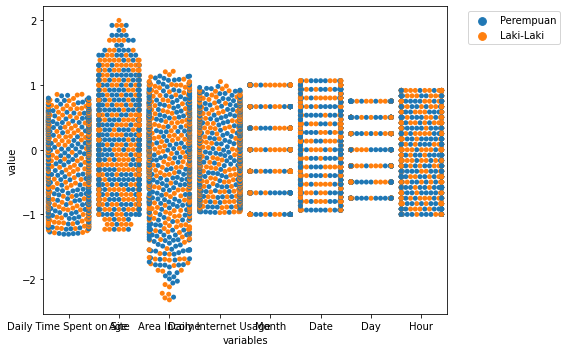

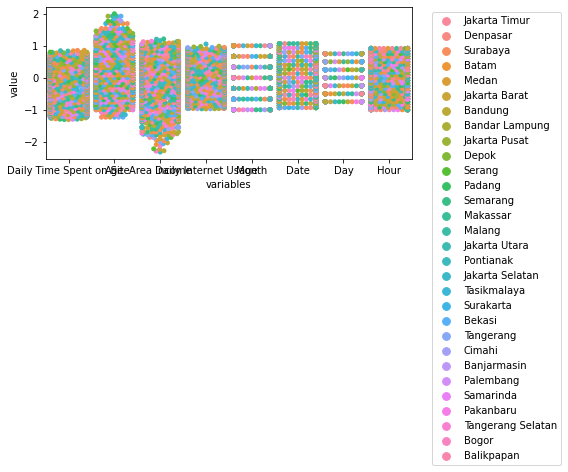

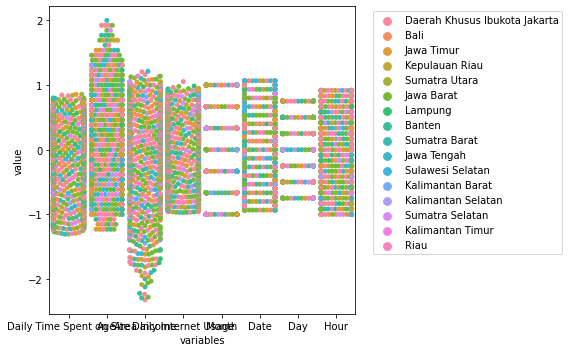

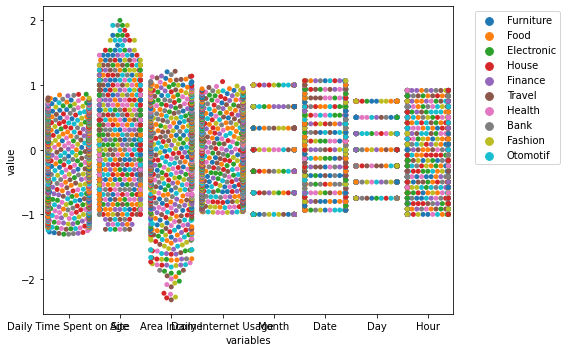

In [ ]:
for i in df[cat_var]:
    df_new = pd.concat([df_scaled, df.loc[:, i]], axis = 1)
    melted_data = pd.melt(df_new, id_vars = i, var_name = "variables", value_name = "value")
    
    plt.figure(figsize = (8, 5))
    sns.swarmplot(x = "variables", y = "value", hue = i, data = melted_data)
    
    plt.xlabel("variables")
    plt.ylabel("value")

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

Sepertinya tidak ada yg terlihat menarik, kemungkinan kolom kategorikal dan numerik tidak berkorelasi dilihat dari sebaran nya

### Multivariate Analysis

#### Correlation with Heatmap

In [ ]:
num_vars = num_var.copy()
num_vars.append('Clicked on Ad')

In [ ]:
df[num_vars].corr()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Month,Date,Day,Hour,Clicked on Ad
Daily Time Spent on Site,1.000000,-0.331424,0.308266,0.518294,-0.006869,-0.020104,0.020462,0.000914,-0.746514
Age,-0.331424,1.000000,-0.179343,-0.370481,0.023689,-0.038162,0.013593,-0.049905,0.492531
Area Income,0.308266,-0.179343,1.000000,0.338080,-0.044826,-0.024857,0.015268,0.035732,-0.477576
Daily Internet Usage,0.518294,-0.370481,0.338080,1.000000,0.019893,-0.013474,0.009998,0.082230,-0.789693
Month,-0.006869,0.023689,-0.044826,0.019893,1.000000,-0.017274,-0.020090,-0.013748,0.016095
Date,-0.020104,-0.038162,-0.024857,-0.013474,-0.017274,1.000000,0.041235,-0.017064,-0.005269
Day,0.020462,0.013593,0.015268,0.009998,-0.020090,0.041235,1.000000,0.007034,0.002003
Hour,0.000914,-0.049905,0.035732,0.082230,-0.013748,-0.017064,0.007034,1.000000,-0.047431
Clicked on Ad,-0.746514,0.492531,-0.477576,-0.789693,0.016095,-0.005269,0.002003,-0.047431,1.000000


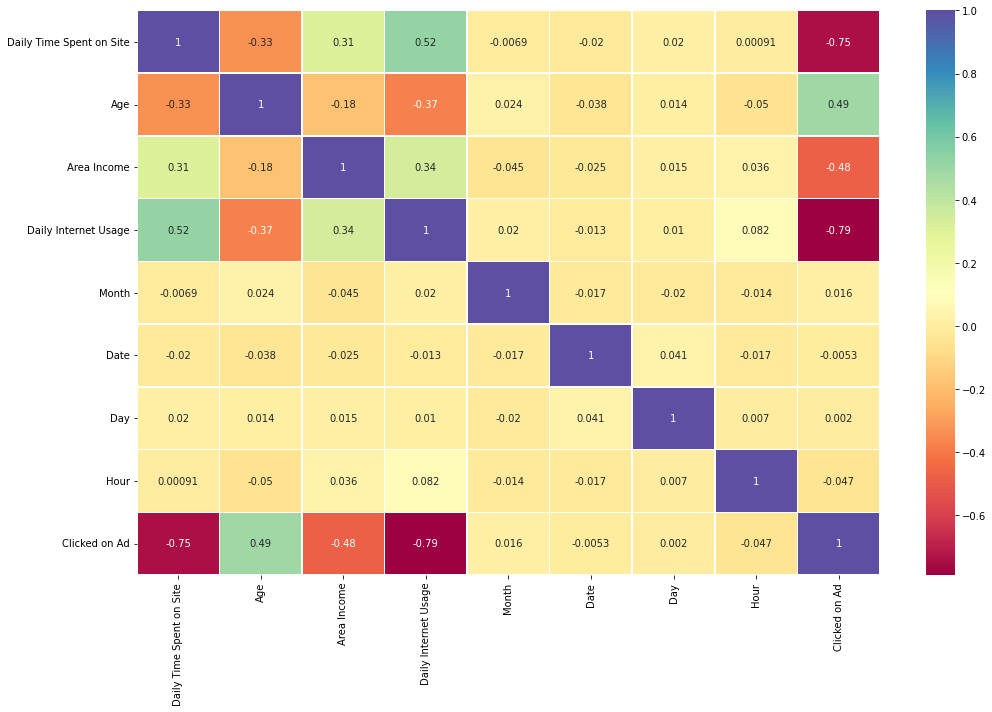

In [ ]:
plt.figure(figsize = (15, 10))
sns.heatmap(data = df[num_vars].corr(method='pearson'), cmap = "Spectral", annot = True, linewidths = 0.5)
plt.tight_layout()
plt.show()

**Analisa Output**

- Kolom yang berkorelasi negatif tinggi dengan target adalah Daily Time Spent on Site dan Daily Internet Usage
- Kolom Area Income berkolerasi moderate negatif dengan Target
- Kolom Age berkolerasi moderate positif dengan Target
- Daily Time Spent dan Daily Internet Usage berkolerasi negatif moderate


### Timeseries Analysis


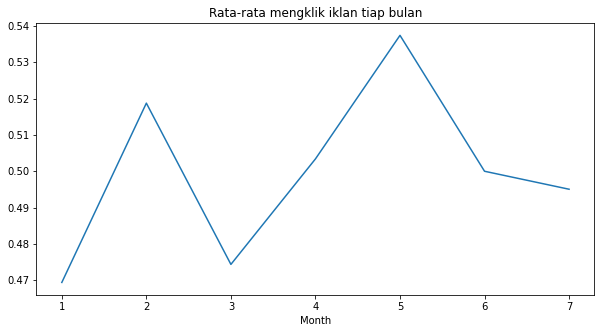

In [ ]:
month_pct = pd.crosstab(df['Month'], df['Clicked on Ad']).apply(lambda a: a/a.sum(), axis=1)[1]
month_pct.plot(figsize=(10,5), title='Rata-rata mengklik iklan tiap bulan')
plt.show()

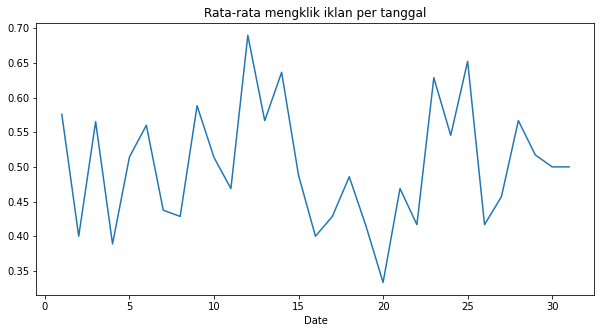

In [ ]:
tanggal_pct = pd.crosstab(df['Date'], df['Clicked on Ad']).apply(lambda a: a/a.sum(), axis=1)[1]
tanggal_pct.plot(figsize=(10,5), title='Rata-rata mengklik iklan per tanggal')
plt.show()

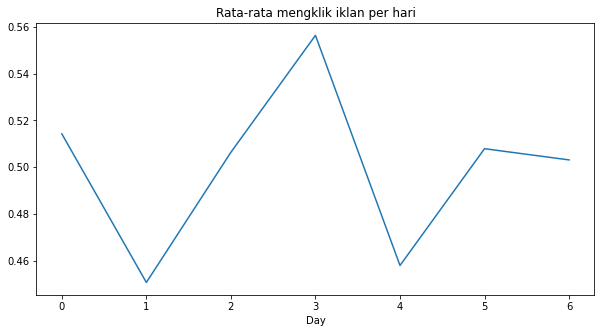

In [ ]:
hari_pct = pd.crosstab(df['Day'], df['Clicked on Ad']).apply(lambda a: a/a.sum(), axis=1)[1]
hari_pct.plot(figsize=(10,5), title='Rata-rata mengklik iklan per hari')
plt.show()

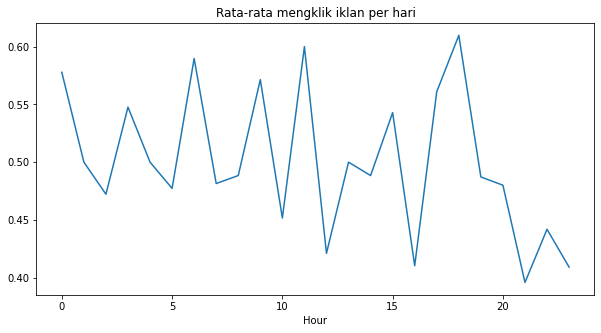

In [ ]:
jam_pct = pd.crosstab(df['Hour'], df['Clicked on Ad']).apply(lambda a: a/a.sum(), axis=1)[1]
jam_pct.plot(figsize=(10,5), title='Rata-rata mengklik iklan per hari')
plt.show()

## Data Processing

### Feature Selection

Ambil kolom week dalam fitur timestamp

In [ ]:
df['Week_Number'] = df['Timestamp'].dt.isocalendar().week

In [ ]:
df.sample(5)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category,Month,Date,Day,Hour,Week_Number
637,91.10,40,388497830.0,198.13,Laki-Laki,2016-03-07 22:51:00,0,Jakarta Utara,Daerah Khusus Ibukota Jakarta,Food,3,7,0,22,10
908,56.91,50,152412540.0,146.44,Perempuan,2016-04-01 05:17:00,1,Surakarta,Jawa Tengah,Electronic,4,1,4,5,13
739,82.37,30,445650240.0,NaN,Perempuan,2016-06-29 04:23:00,0,Palembang,Sumatra Selatan,House,6,29,2,4,26
112,71.00,22,392471660.0,211.87,Perempuan,2016-03-14 06:46:00,0,Bandung,Jawa Barat,House,3,14,0,6,11
158,80.46,27,NaN,NaN,Laki-Laki,2016-02-04 02:13:00,0,Bandar Lampung,Lampung,Bank,2,4,3,2,5


Drop kolom city, karena terlalu banyak nilai unik

In [ ]:
df.drop('city', axis=1, inplace=True)

### Split Data

Pemisahan data Training dan data Testing dengan rasio 70:30 dan rasio target sama

In [ ]:
X = df.drop('Clicked on Ad', axis=1)
y = df['Clicked on Ad']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

1    0.5
0    0.5
Name: Clicked on Ad, dtype: float64
1    0.5
0    0.5
Name: Clicked on Ad, dtype: float64


### Handling Missing Values

In [ ]:
df.isnull().sum()

Daily Time Spent on Site    13
Age                          0
Area Income                 13
Daily Internet Usage        11
Male                         3
Timestamp                    0
Clicked on Ad                0
province                     0
category                     0
Month                        0
Date                         0
Day                          0
Hour                         0
Week_Number                  0
dtype: int64

Melakukan imputasi dengan median bagi numerikal dan mode bagi categorikal

### Feature Encoding

Kolom kategorikal yang terdapat di dataset ini adalah bertipe nominal, sehingga dilakukan OneHotEncoding

### Feature Transform

Karena kolom hampir semua berdistribusi normal maka dilakukan normalisasi menggunakan MinmaxScaler

#### Create Pipeline

In [ ]:
cv = X_train.select_dtypes(include='object').columns.to_list()
nm = X_train.select_dtypes(exclude=['object','datetime']).columns.to_list()

In [ ]:
#create pipeline
num_pip = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

cat_pip = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ('numeric', num_pip, nm),
    ('categoric', cat_pip, cv)
])

Keterangan:
0-8 Numerical
9-33 Categorikal

In [ ]:
mixing = []
mixing.extend(nm)
mixing.extend(cv)

for i,j in enumerate(mixing):
  print(i, j, df[j].nunique())

0 Daily Time Spent on Site 890
1 Age 43
2 Area Income 987
3 Daily Internet Usage 955
4 Month 7
5 Date 31
6 Day 7
7 Hour 24
8 Week_Number 30
9 Male 2
10 province 16
11 category 10


## Modelling

### Model yang ditest

In [ ]:
LR = LogisticRegression(random_state=42)
KNN = KNeighborsClassifier()
nb = GaussianNB()
dtree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42, probability=True)

In [ ]:
def eval_classification(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)
  y_pred_proba_train = model.predict_proba(X_train)
  accuracy = accuracy_score(y_test,y_pred)
  accuracy_train = accuracy_score(y_train,y_pred_train)
  recall = recall_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  AUC_test = roc_auc_score(y_test, y_pred_proba[:, 1])
  AUC_train = roc_auc_score(y_train, y_pred_proba_train[:, 1])

  result = {
      'Model' : str(model),
      'Akurasi_Train' : accuracy_train,
      'Akurasi_Test' : accuracy,
      'Presisi' : precision,
      'Recall' : recall,
      'F1' : f1,
      'roc_auc_train' : AUC_train,
      'roc_auc_test' : AUC_test
      }

  return result

### Menggunakan Normalisasi

In [ ]:
preprocessor.fit(X_train)
train_X = preprocessor.transform(X_train)
test_X =preprocessor.transform(X_test)

In [ ]:
models = [LR, KNN, nb, dtree, rf, svm]

list_models = []

for model in models:
  list_models.append(eval_classification(model, train_X, y_train, test_X, y_test))

In [ ]:
pd.DataFrame(list_models)

,Model,Akurasi_Train,Akurasi_Test,Presisi,Recall,F1,roc_auc_train,roc_auc_test
0,LogisticRegression(random_state=42),0.970000,0.980000,0.993151,0.966667,0.979730,0.993567,0.990044
1,KNeighborsClassifier(),0.870000,0.760000,0.778571,0.726667,0.751724,0.940343,0.824667
2,GaussianNB(),0.921429,0.890000,0.872611,0.913333,0.892508,0.962147,0.923244
3,DecisionTreeClassifier(random_state=42),1.000000,0.943333,0.929032,0.960000,0.944262,1.000000,0.943333
4,RandomForestClassifier(random_state=42),1.000000,0.970000,0.973154,0.966667,0.969900,1.000000,0.992444
5,"SVC(probability=True, random_state=42)",0.977143,0.973333,0.986301,0.960000,0.972973,0.994400,0.990400


### Tanpa melakukan normalisasi

In [ ]:
#create pipeline without normalization
num_pip2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

cat_pip2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor2 = ColumnTransformer([
    ('numeric', num_pip2, nm),
    ('categoric', cat_pip2, cv)
])

In [ ]:
preprocessor2.fit(X_train)
train_X2 = preprocessor2.transform(X_train)
test_X2 =preprocessor2.transform(X_test)

In [ ]:
models = [LR, KNN, nb, dtree, rf, svm]

list_models = []

for model in models:
  list_models.append(eval_classification(model, train_X2, y_train, test_X2, y_test))

pd.DataFrame(list_models)

,Model,Akurasi_Train,Akurasi_Test,Presisi,Recall,F1,roc_auc_train,roc_auc_test
0,LogisticRegression(random_state=42),0.500000,0.500000,0.000000,0.000000,0.000000,0.759412,0.790889
1,KNeighborsClassifier(),0.762857,0.673333,0.688406,0.633333,0.659722,0.848755,0.725978
2,GaussianNB(),0.698571,0.750000,0.804878,0.660000,0.725275,0.761763,0.788667
3,DecisionTreeClassifier(random_state=42),1.000000,0.943333,0.929032,0.960000,0.944262,1.000000,0.943333
4,RandomForestClassifier(random_state=42),1.000000,0.970000,0.973154,0.966667,0.969900,1.000000,0.990289
5,"SVC(probability=True, random_state=42)",0.701429,0.746667,0.830357,0.620000,0.709924,0.760971,0.789689


**Analisa Output**
- Terlihat bahwa tanpa menggunakan normalisasi, model cenderung overfit sehingga model yang akan dipakai adalah yg sudah dinormalisasi sebelumnya
- terlihat model yang paling baik dari segi akurasi, presisi, recall dan roc_auc adalah LogisticRegression

### Classification with LogisticRegression

In [ ]:
#create pipeline with model
num_pip = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

cat_pip = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ('numeric', num_pip, nm),
    ('categoric', cat_pip, cv)
])

modelling = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', LogisticRegression(random_state=42))
])

In [ ]:
modelling.fit(X_test, y_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Daily Time Spent on Site',
                                                   'Age', 'Area Income',
                                                   'Daily Internet Usage',
                                                   'Month', 'Date', 'Day',
                                                   'Hour', 'Week_Number']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                             

In [ ]:
y_pred = modelling.predict(X_test)

In [ ]:
y_pred

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

### Confusion Matrix

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       150
           1       1.00      0.97      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



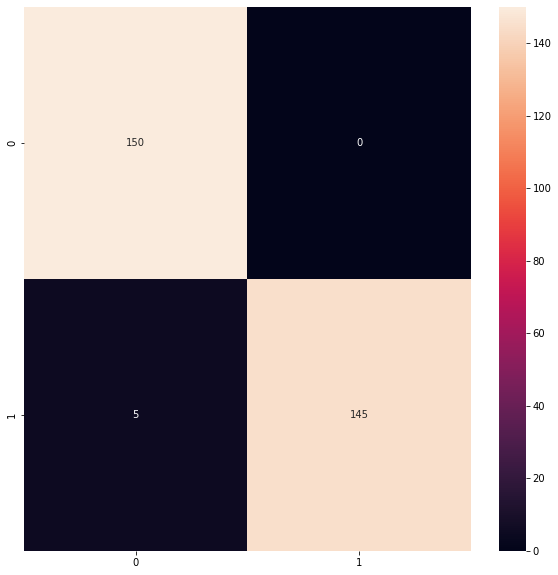

In [ ]:
conf = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt="g")
plt.show()

### Feature Importance

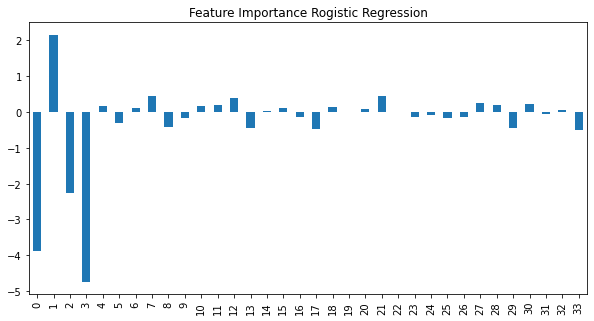

In [ ]:
# get importance
importance = modelling['algo'].coef_[0]

pd.DataFrame(importance)[0].plot.bar(figsize=(10,5), title='Feature Importance Rogistic Regression')
plt.show()

**Analisa Output**
- Feature yang berpengaruh terhadap model adalah
  - 3 Daily Internet Usage
  - 0 Daily Time Spent on Site
  - 1 Age
  - 2 Area Income

- Terlihat feature diatas sangat berkorelasi dengan target dengan dua fitur utama adalah Daily Internet Usage dan Dailiy Time Spent on Site